### Importing Packages 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

import re
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer , HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix , classification_report , accuracy_score , f1_score

import joblib

import warnings
warnings.filterwarnings('ignore')

### Importing the data

In [4]:
df = pd.read_csv('drugs.tsv' , sep='\t')

In [5]:
df = df[['review' , 'rating']]

In [6]:
df.head()

,review,rating
0,"""It has no side effect, I take it in combinati...",9.0
1,"""My son is halfway through his fourth week of ...",8.0
2,"""I used to take another oral contraceptive, wh...",5.0
3,"""This is my first time using any form of birth...",8.0
4,"""Suboxone has completely turned my life around...",9.0


In [19]:
df['review'][161294] # negative 

'"Limited improvement after 4 months, developed bad rash and MD refused to continue medication."'

In [21]:
df['review'][0]

'"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"'

### EDA and Visualization 

In [5]:
df.shape

(161297, 2)

In [6]:
df.dropna(inplace=True)

In [7]:
# deal with html special symbols

from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

df['review'] = df.review.apply(lambda x: strip_tags(x))

In [8]:
# contractions --> you've to you have
import contractions

df['review'] = df['review'].map(lambda x: contractions.fix(x))

In [9]:

# converting to lower case 
df['review'] = df['review'].str.lower()

In [10]:
# remove numbers
df['review'] = df['review'].replace(to_replace=['\d+'] , value = '', regex = True)

In [11]:
# removing all symbols and punctuations 
df['review'] = df['review'].replace(to_replace='[!”#$%&’()*+,-./:;<=>?@[\]^_`{|}~]' , value = '', regex = True)

In [12]:
# removing the quotes
df['review'] = df['review'].str.replace('"' , '')

In [13]:
df['rating'] = df['rating'].apply(lambda x: 1 if x > 7 else 0)
df.head()

,review,rating
0,it has no side effect i take it in combination...,1
1,my son is halfway through his fourth week of i...,1
2,i used to take another oral contraceptive whic...,0
3,this is my first time using any form of birth ...,1
4,suboxone has completely turned my life around ...,1


In [14]:
df.shape

(161297, 2)

In [15]:
# Top 10 most frequent words 
reviews = df.review.str.cat(sep=' ')
#function to split text into word
tokens = word_tokenize(reviews)
vocabulary = set(tokens)
print('-'*75)
print('The total lenght of the vocalbulary is {}'.format(len(vocabulary)))
print('-'*75)
frequency_dist = nltk.FreqDist(tokens)
pd.DataFrame(sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:10] , columns=['Most frequent words'])

---------------------------------------------------------------------------
The total lenght of the vocalbulary is 66494
---------------------------------------------------------------------------


,Most frequent words
0,i
1,and
2,the
3,to
4,it
5,my
6,a
7,have
8,for
9,not


In [16]:
# Top 10 most frequent words after removing the stopwords
stop_words = set(stopwords.words('english'))
tokens = [w for w in tokens if not w in stop_words]
frequency_dist = nltk.FreqDist(tokens)
pd.DataFrame(sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:10] , columns = ['Most frequent words'])

,Most frequent words
0,day
1,side
2,taking
3,years
4,pain
5,first
6,effects
7,mg
8,take
9,months


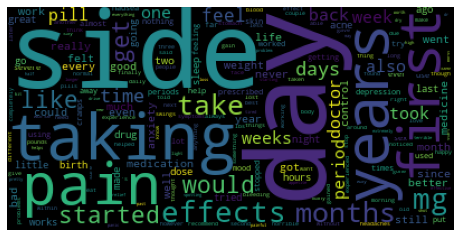

In [17]:
wordcloud = WordCloud().generate_from_frequencies(frequency_dist)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [18]:
lemma = WordNetLemmatizer()
article_corpus = []

for each in range(50000):
    text = re.sub(r'[^a-zA-Z]' , ' ' , df.review[each])
    text = text.lower()
    text = text.split()
    
    text = [lemma.lemmatize(each) for each in text if each not in set(stopwords.words('english'))]
    text = ' '.join(text)
    article_corpus.append(text)

In [19]:
#with open("file.txt", "w") as output:
#    output.write(str(article_corpus))

In [20]:
Tfidf = TfidfVectorizer(max_features= 5000 , ngram_range=(1,3))
X = Tfidf.fit_transform(article_corpus).toarray()

In [24]:
y = df['rating'][:50000]

In [25]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.25, random_state = 42)

In [26]:
X_train.shape , X_test.shape, y_train.shape, y_test.shape

((37500, 5000), (12500, 5000), (37500,), (12500,))

### Linear SVC

In [27]:
clf = LinearSVC()
clf.fit(X_train, y_train)

train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

print('Training Accuracy:', accuracy_score(y_train, train_pred))
print('Testing Accuracy:', accuracy_score(y_test, test_pred))

Training Accuracy: 0.8524533333333333
Testing Accuracy: 0.79392


In [28]:
print(confusion_matrix(y_test , test_pred))

[[3543 1432]
 [1144 6381]]


In [29]:
print(classification_report(y_test , test_pred))

              precision    recall  f1-score   support

           0       0.76      0.71      0.73      4975
           1       0.82      0.85      0.83      7525

    accuracy                           0.79     12500
   macro avg       0.79      0.78      0.78     12500
weighted avg       0.79      0.79      0.79     12500



In [32]:
print(f1_score(y_test , test_pred))

0.8320511148780805


### Saving the model

In [33]:
# Save the vectorizer as a pickle in a file
joblib.dump(Tfidf, 'Tfidf_vector.pkl')

['Tfidf_vector.pkl']

In [34]:
# Save the model as a pickle in a file 
joblib.dump(clf, 'linear_svc.pkl') 

['linear_svc.pkl']

### Loading the model from pickle file to validate

In [2]:
Linear_svc = joblib.load('linear_svc.pkl')
tfidf_5000 = joblib.load('Tfidf_vector.pkl')

In [7]:
x_val = df.review[16000]
x_val

'"I find it very effective much better than synthetic drugs. Feel much better taking it."'

In [8]:
X_val = tfidf_5000.transform([x_val]).toarray()

In [9]:
X_val.shape

(1, 5000)

In [10]:
val_pred = Linear_svc.predict(X_val)

In [13]:
int(val_pred)

1

### The model gives the same performance , thus confirming it is generalized 